# Plant Disease Prediction

## Importing essential packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import models,layers

## Fetching data

In [2]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=25

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(class_names)

3

## Plottingimages in batches

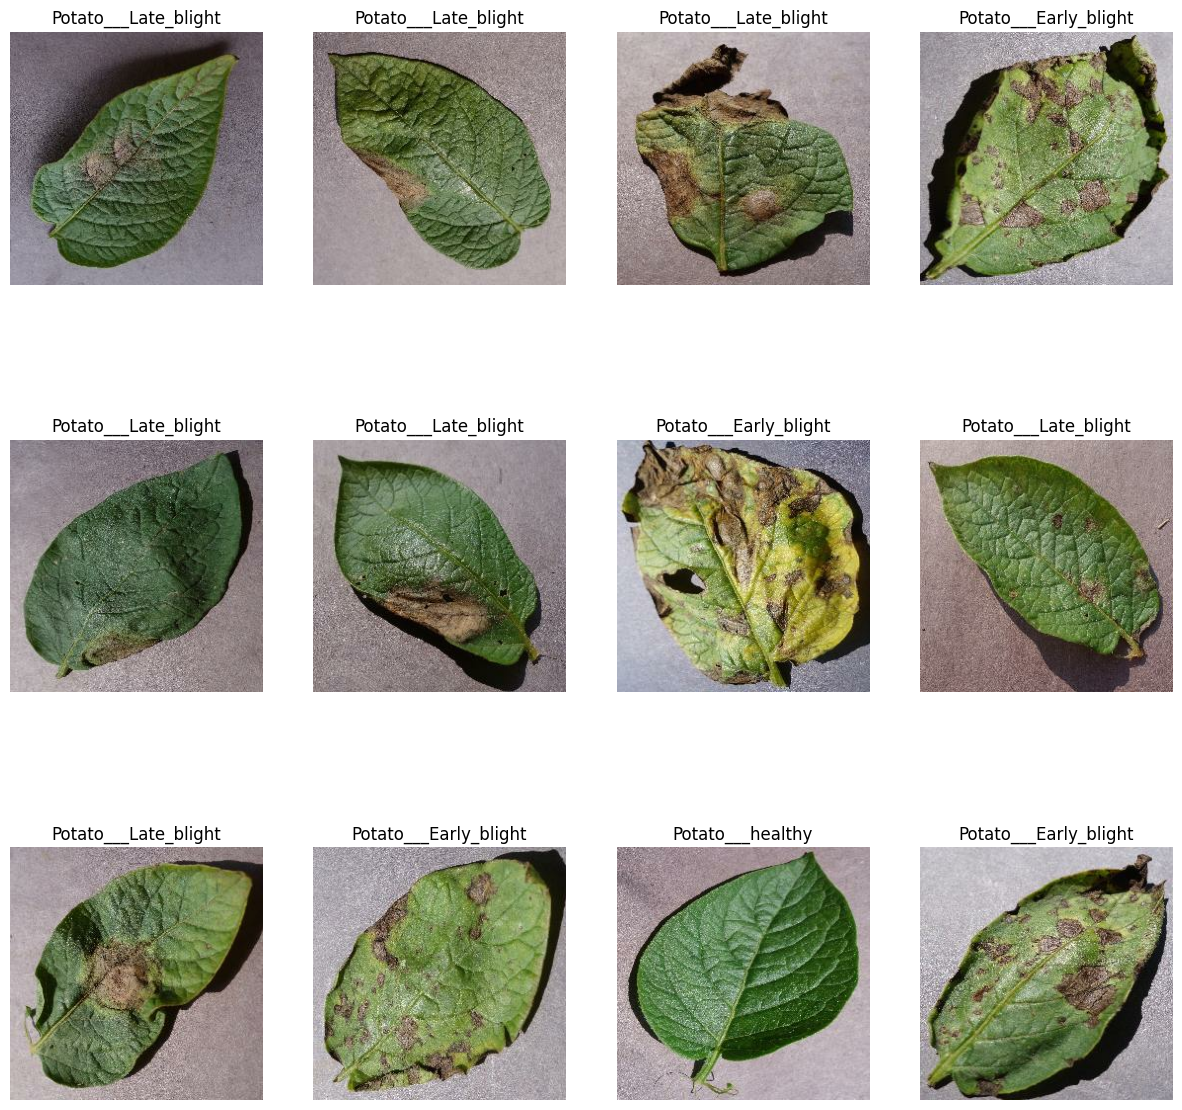

In [7]:
plt.figure(figsize=(15,15))
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        #print(batch[i].shape)
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[ label_batch[i] ])

## A function to get train, test ,validation data split
### 80%==>traindataset
### 20%==>testdataset
### 10%==>validation
### 10%==>test
    

In [8]:
def get_train_test_val(dataset,train_split=0.8,val_split=0.1,shuffle=False):
    if shuffle:
        dataset=dataset.shuffle()
    ds_size=len(dataset)
    
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    
    train_dataset=dataset.take(train_size)
    val_dataset=dataset.skip(train_size).take(val_size)
    test_dataset=dataset.skip(train_size+val_size)
    return train_dataset,val_dataset,test_dataset

    
    
    

In [9]:
train_ds,val_ds,test_ds=get_train_test_val(dataset)

In [10]:
len(val_ds)

6

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

## Model Building

In [12]:
resize_and_rescale=models.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1/255),
    
])

In [13]:
DataAugumentaion=models.Sequential([
    layers.RandomFlip("horizontal"),

    layers.RandomContrast(0.2)
])

In [14]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
model=models.Sequential([
    resize_and_rescale,
    DataAugumentaion,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
    
])
model.build(input_shape=input_shape)

C:\Users\Pavan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 57600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
model.fit(train_ds,epochs=10,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 98s 2s/step - loss: 0.2914 - accuracy: 0.8854 - val_loss: 0.1770 - val_accuracy: 0.9375
Epoch 2/10
54/54 [==============================] - 95s 2s/step - loss: 0.2187 - accuracy: 0.9103 - val_loss: 0.1594 - val_accuracy: 0.9427
Epoch 3/10
54/54 [==============================] - 98s 2s/step - loss: 0.1409 - accuracy: 0.9416 - val_loss: 0.1482 - val_accuracy: 0.9323
Epoch 4/10
54/54 [==============================] - 96s 2s/step - loss: 0.1709 - accuracy: 0.9369 - val_loss: 0.1870 - val_accuracy: 0.9167
Epoch 5/10
54/54 [==============================] - 158s 3s/step - loss: 0.1304 - accuracy: 0.9554 - val_loss: 0.1878 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 97s 2s/step - loss: 0.0863 - accuracy: 0.9659 - val_loss: 0.0699 - val_accuracy: 0.9740
Epoch 7/10
54/54 [==============================] - 95s 2s/step - loss: 0.0632 - accuracy: 0.9769 - val_loss: 0.0413 - val_accuracy: 0.9844
Epoch 8/10
54/54 [=

## Evaluating the model performance

In [25]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 295ms/step - loss: 0.0505 - accuracy: 0.9914


[0.050496865063905716, 0.9913793206214905]

## Saving the trained model

In [26]:
model.save('version1.h5')

## model load

In [10]:
model=tf.keras.models.load_model('version1.h5')

In [11]:
model.evaluate(test_ds)

8/8 [==============================] - 10s 482ms/step - loss: 0.0661 - accuracy: 0.9828


[0.06610142439603806, 0.982758641242981]

In [20]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 466ms/step - loss: 0.0280 - accuracy: 0.9957


In [ ]:
history=model.fit(train_ds,epochs=10,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 110s 2s/step - loss: 0.0461 - accuracy: 0.9838 - val_loss: 0.0898 - val_accuracy: 0.9688
Epoch 2/10
23/54 [===========>..................] - ETA: 55s - loss: 0.1616 - accuracy: 0.9348

In [13]:
version=1

In [16]:
model.save(f"../models/{version}.h5")

In [40]:
import os
v=max([int(i) for i in os.listdir("../models/")+['0']])+1

model.save(f"../models/{v}/{v}.h5")

In [41]:
print(os.listdir("../models/"))

['1', '2', '3']
